# Intro to the Notebook

This notebook us used to create a model to classify between different lung diseases based on Xrays (Covid , Pneumonia and normal lungs x rays).
This model inherits some pre trained chracteristics from the InceptionV3 model. Lear about Inception V3 <a href="https://cloud.google.com/tpu/docs/inception-v3-advanced">here </a>

## Datasets 

<a href="https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database">This dataset</a> from kaggle after some adjustments (splitted into train, test and validation sets, oversampling of Pneumonia images (in val set), down sampling of normal lung images) is used for the training, testing and validation of this model.

## Imbalanced dataset problem

As the data set was imbalanced I performed the following tasks to deal with the problem

<ul>
<li>Upsampling of Pneumonia images because they were low in amount as compared to the Covid and Normal images</li>
<li>Downsampling of lungs images because they were in high quantity</li>
<li>Used keras's built in class_weight feature</li>
</ul>

## Downloads 

Here are some downloads for you

<a href="https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5">InceptionV3 Weights</a> (Download the model weights for Inception V3) <br>
<a href="https://drive.google.com/file/d/1KBKUyLmSb7fHo5_uhpFZvi9661hEF4f8/view?usp=sharing">Trained Model</a> (Download the trained model "LossOptimized")<br>
<a href="https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database">Original Dataset</a> (Download the original dataset for training from kaggle)<br>
<!-- <a href="">Tweaked Dataset</a> (Download the dataset I used for training the model. Splitted into (train + test + validation)) -->

A link to modified dataset will be available here soon!

In [1]:

import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model
from keras_preprocessing.image import ImageDataGenerator

In [8]:
train_path  = "CovidData/train"
valid_path  = "CovidData/validation"
test_path   = "CovidData/test"

In [ ]:
#Download the pretrained weights

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O ./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [55]:
# Load the model weights for inception V3

pre_model = InceptionV3( input_shape=(250,250,3), include_top= False, weights=None)
pre_model.load_weights('./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [56]:
# Freeze the model weights 

for layer in pre_model.layers:
    layer.trainable = False

In [57]:
#Pick a layer from the InceptionV3 model and then add your own layers ahead
LastLayer = pre_model.get_layer('mixed7')
LastOutput = LastLayer.output


#Get Output from the last layer of inception V3 and then add your own layers
x = tf.keras.layers.Flatten()(LastOutput)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

In [62]:
# Compiling the model

model = Model(pre_model.input,x)
model.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 124, 124, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 124, 124, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                           

In [9]:

# Load data (Xray images) from the directories Using keras.ImageDataGenerator


training_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')



validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	train_path,
	target_size=(250,250),
	class_mode='categorical',
  batch_size=100
)

validation_generator = validation_datagen.flow_from_directory(
	valid_path,
	target_size=(250,250),
	class_mode='categorical',
  batch_size=50
)

test_datagen = ImageDataGenerator(rescale=1/255)
test_generator =  test_datagen.flow_from_directory(
    test_path,
    target_size=(250,250),
    batch_size = 100,
    class_mode = 'categorical'
)

#print the numerical labels assigned to each class

label_map = (train_generator.class_indices)
print(label_map)

Found 12965 images belonging to 3 classes.
Found 2552 images belonging to 3 classes.
Found 3929 images belonging to 3 classes.
{'Covid': 0, 'Normal': 1, 'Pneumonia': 2}


In [66]:
# A dictionary containing the weight to be given to each class by the loss function
# The weight is given by using statistics
# # Weight of Norma (class label:0 ) is 1
# Weight of Covid (class label:0) is given by [No of Normal images / No of Covid Images]
# Weight of Pneumonia (class label:2) is given by [No of Normal images/ No of pneumonia images]

class_weights = {0:2.82, 1:1, 2:7.58}

In [67]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

#Saving the best model by using keras early stopping and based on validation loss

stopHere= EarlyStopping(monitor= "val_loss" , min_delta= 0.01, patience= 7, verbose=1)
checkpoint = ModelCheckpoint(filepath="LossOptimized", monitor="val_loss", verbose=1, save_best_only= True)



In [68]:

# Training the model

history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 40,
            epochs = 20,
            class_weight=class_weights,
            validation_steps = 1,
            verbose = 1,
            callbacks=[stopHere, checkpoint])

Epoch 1/20
40/40 [==============================] - ETA: 0s - loss: 6.3773 - accuracy: 0.6318
Epoch 1: val_loss improved from inf to 0.61808, saving model to LoddOptimized
INFO:tensorflow:Assets written to: LoddOptimized\assets
40/40 [==============================] - 246s 6s/step - loss: 6.3773 - accuracy: 0.6318 - val_loss: 0.6181 - val_accuracy: 0.8000
Epoch 2/20
40/40 [==============================] - ETA: 0s - loss: 0.8776 - accuracy: 0.7960
Epoch 2: val_loss improved from 0.61808 to 0.44336, saving model to LoddOptimized
INFO:tensorflow:Assets written to: LoddOptimized\assets
40/40 [==============================] - 233s 6s/step - loss: 0.8776 - accuracy: 0.7960 - val_loss: 0.4434 - val_accuracy: 0.8400
Epoch 3/20
40/40 [==============================] - ETA: 0s - loss: 0.6879 - accuracy: 0.8242
Epoch 3: val_loss improved from 0.44336 to 0.21185, saving model to LoddOptimized
INFO:tensorflow:Assets written to: LoddOptimized\assets
40/40 [==============================] - 236s 6s

In [71]:
model.save('LungMLTrained') # Saving the model after traing to a different location

INFO:tensorflow:Assets written to: FinalBestModel\assets


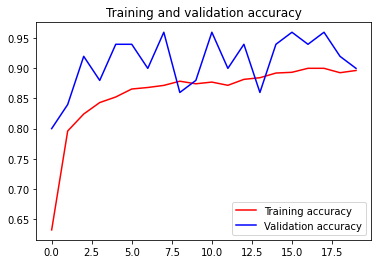

<Figure size 432x288 with 0 Axes>

In [70]:

# Ploting TRAINING ACCURACY vs VALIDATION ACCURACY

import matplotlib.pyplot as plt   


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

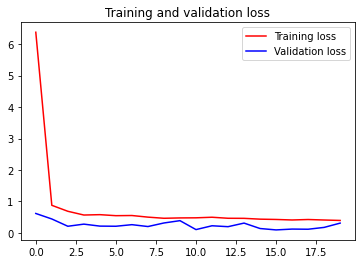

<Figure size 432x288 with 0 Axes>

In [72]:
# PLOTTING TRAINING LOSS VS VALIDATION LOSS

plt.plot(epochs,loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [75]:
model.evaluate(test_generator)  #testing the final model (Saved after training LungMLTrained)

40/40 [==============================] - 200s 5s/step - loss: 0.1834 - accuracy: 0.9348


[0.183370903134346, 0.9348434805870056]

In [4]:
model2 = tf.keras.models.load_model('LossOptimized')  # Load the best model we save during traing

In [ ]:
model2.evaluate(test_generator) # Evaluate it on test set


# Though the previous model performed a little better on test set 
# But on further evaluation I found that for classes such as PNEUMONIA and COVID this model was actually performing better So, I choosed this one to be used
# Anyways, the difference wasn't very large and you can use any of the model you want 

40/40 [==============================] - 182s 5s/step - loss: 0.1873 - accuracy: 0.9331


[0.1873374581336975, 0.9330618381500244]

In [13]:
# Now test the mopdel from some random images (Downloaded from Google)

from keras.preprocessing import image
img = image.load_img('Add a path to image here', target_size=(250, 250))
x = image.img_to_array(img) 
x /= 255  # Rescaling images
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model2.predict(images) # Predict the class of images

print(classes)

tf.Tensor(2, shape=(), dtype=int64)
[[1.3172001e-04 2.7113149e-03 9.9715698e-01]]


In [15]:
 # Ecoding the label from above (1st method)
encode_label = np.argmax(classes,axis=1)
lb = {}
for key,value in enumerate(label_map):
    lb[key] = value

print(lb[encode_label[0]])

Pneumonia


In [ ]:
# encoding the label (2nd Method)

encode_label = np.argmax(classes,axis=1)

In [16]:
# get probability for the class with highest chances
max(classes[0])

0.997157